# Patterns

## Class Complexity


We've seen that using object orientation can produce quite complex class structures, with classes owning each other, instantiating each other,
and inheriting from each other.

There are lots of different ways to design things, and decisions to make.

> - Should I inherit from this class, or own it as a member variable? ("is a" vs "has a")
> - How much flexibility should I allow in this class's inner workings?
> - Should I split this related functionality into multiple classes or keep it in one?


## Design Patterns


Programmers have noticed that there are certain ways of arranging classes that work better than others.

These are called "design patterns".

They were first collected on one of the [world's first Wikis](http://c2.com/cgi/wiki?WelcomeVisitors), 
as the [Portland Pattern Repository](http://c2.com/cgi-bin/wiki?PatternIndex).


## Reading a pattern


A description of a pattern in a book such as the [Gang Of Four](https://www.worldcat.org/title/design-patterns-elements-of-reusable-object-oriented-software/oclc/31171684)
book ([UCL Library](https://ucl-new-primo.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=UCL_LMS_DS21146030410004761&context=L&vid=UCL_VU2&search_scope=CSCOP_UCL&tab=local&lang=en_US)) usually includes:

* **Intent** - what's the purpose
* **Motivation** - why you want to use it
* **Applicability** - when do you want to use it
* **Structure** - what does it look like (e.g., UML diagram)
* **Participants** - What are the different classes in it
* **Collaborations** - how they work together
* **Consequences** - What are the results and trade-offs
* **Implementation** - How is it implemented
* **Sample Code** - In practice.


## Introducing Some Patterns


There are lots and lots of design patterns, and it's a great literature to get into to
read about design questions in programming and learn from other people's experience.

We'll just show a few in this session:

* [Factory Method](#Factory-Pattern)
* [Builder](#Builder)
* [Strategy](#Strategy)
* [Model-View-Controller](#Model-View-Controller)

## Supporting code

In [1]:
%matplotlib inline
from unittest.mock import Mock
from IPython.display import SVG, HTML


def yuml(model):
    return SVG(url=f"http://yuml.me/diagram/boring/class/{model}")

## Factory Pattern


Here's what the Gang of Four Book says about Factory Method:

**Intent**:  Define an interface for creating an object, but let subclasses decide which class to instantiate.
Factory Method lets a class defer instantiation to subclasses.

**Applicability**: Use the Factory method pattern when:

* A class can't anticipate the class of objects it must create
* A class wants its subclasses to specify the objects it creates

This is pretty hard to understand, so let's look at an example.


### Factory UML

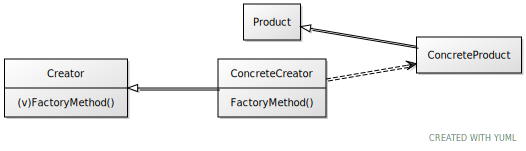

In [2]:
yuml(
    "[Product]^-[ConcreteProduct],"
    + "[Creator|(v)FactoryMethod()]^-[ConcreteCreator|FactoryMethod()],"
    + "[ConcreteCreator]-.->[ConcreteProduct]"
)

### Factory Example


An "agent based model" is one like the Boids model from last week:
agents act and interact under certain rules. Complex phenomena can be described by simple
agent behaviours.




In [3]:
class AgentModel:
    def simulate(self):
        for agent in agents:
            for target in agents:
                agent.interact(target)
        agent.simulate()

### Agent model constructor


This logic is common to many kinds of Agent based model (ABM), so we can imagine a common class
for agent based models: the constructor could parse a configuration specifying how many agents of each type to create,
their initial conditions and so on.

However, this common constructor doesn't know what kind of agent to create; as a common base, it could be a model of boids,
or the agents could be remote agents on foreign servers, or they could even be physical hardware robots connected to the driving model
over Wifi!

We need to defer the construction of the agents. We can do this with polymorphism: each derived class of the ABM can have an appropriate
method to create its agents:




In [4]:
class AgentModel:
    def __init__(self, config):
        self.agents = []
        for agent_config in config:
            self.agents.append(self.create(**agent_config))

This is the *factory method* pattern: a common design solution to the need to defer the construction of daughter objects to a derived class. `self.create` is not defined here, but in each of the agents that inherits from `AgentModel`. Using polimorphism to get deffered behaviour on what you want to create.

### Agent derived classes

The type that is created is different in the different derived classes:

In [5]:
class BirdModel(AgentModel):
    def create(self, agent_config):
        return Boid(agent_config)




Agents are the base product, boids or robots are a ConcreteProduct.




In [6]:
class WebAgentFactory(AgentModel):
    def __init__(self, url):
        self.url = url
        self.connection = AmazonCompute.connect(url)
        AgentModel.__init__(self)

    def create(self, agent_config):
        return OnlineAgent(agent_config, self.connection)




There is no need to define an explicit base interface for the "Agent" concept in Python: anything that responds to "simulate" and "interact" 
methods will do: this is our Agent concept.


### Refactoring to Patterns


I personally have got into a terrible tangle trying to make base classes which somehow
"promote" themselves into a derived class based on some code in the base class.

This is an example of an "Antipattern": like a Smell, this is a recognised Wrong Way
of doing things.

What I should have written was a Creator with a FactoryMethod.


Consider the following code:

In [7]:
class AgentModel:
    def simulate(self):
        for agent in agents:
            for target in agents:
                agent.interact(target)
            agent.simulate()


class BirdModel(AgentModel):
    def __init__(self, config):
        self.boids = []
        for boid_config in config:
            self.boids.append(Boid(**boid_config))


class WebAgentFactory(AgentModel):
    def __init__(self, url, config):
        self.url = url
        connection = AmazonCompute.connect(url)
        AgentModel.__init__(self)
        self.web_agents = []
        for agent_config in config:
            self.web_agents.append(OnlineAgent(agent_config, connection))

The agent creation loop is almost identical in the two classes; so we can be sure we need to refactor it away; but the **type** that is created is different
in the two cases, so this is the smell that we need a factory pattern.

## Builder

**Intent**: Separate the steps for constructing a complex object from its final representation.

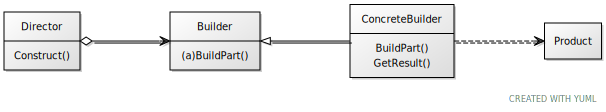

In [8]:
yuml(
    "[Director|Construct()]<>->[Builder|(a)BuildPart()],"
    + "[Builder]^-[ConcreteBuilder|BuildPart();GetResult()],"
    + "[ConcreteBuilder]-.->[Product]"
)

### Builder example


Let's continue our Agent Based modelling example.

There's a lot more to defining a model than just adding agents of different kinds: we need to define boundary conditions,
specify wind speed or light conditions.

We could define all of this for an imagined advanced Model with a very very long constructor, with lots of optional arguments:




In [9]:
class Model:
    def __init__(
        self,
        xsize,
        ysize,
        agent_count,
        wind_speed,
        agent_sight_range,
        eagle_start_location,
    ):
        pass

### Builder preferred to complex constructor


However, long constructors easily become very complicated. Instead, it can be cleaner to define a Builder for models. A builder is like a 
deferred factory: each step of the construction process is implemented as an individual method call, and the completed object
is returned when the model is ready.





In [10]:
Model = Mock()  # Create a temporary mock so the example works!

In [11]:
class ModelBuilder:
    def start_model(self):
        self.model = Model()
        self.model.xlim = None
        self.model.ylim = None

    def set_bounds(self, xlim, ylim):
        self.model.xlim = xlim
        self.model.ylim = ylim

    def add_agent(self, xpos, ypos):
        pass  # Implementation here

    def finish(self):
        self.validate()
        return self.model

    def validate(self):
        assert self.model.xlim is not None
        # Check that the all the
        # parameters that need to be set
        # have indeed been set.




Inheritance of an Abstract Builder for multiple concrete builders could be used where there might be multiple ways to build models
with the same set of calls to the builder: for example a version of the model builder yielding models which can be executed
in parallel on a remote cluster.


### Using a builder

In [12]:
builder = ModelBuilder()
builder.start_model()

builder.set_bounds(500, 500)
builder.add_agent(40, 40)
builder.add_agent(400, 100)

model = builder.finish()
model.simulate()

<Mock name='mock().simulate()' id='140306961468112'>

### Avoid staged construction without a builder.


We could, of course, just add all the building methods to the model itself, rather than having the model be yielded from a separate builder.

This is an antipattern that is often seen: a class whose `__init__` constructor alone is insufficient for it to be ready to use. A series of
methods must be called, in the right order, in order for it to be ready to use.

This results in very fragile code: its hard to keep track of whether an object instance is "ready" or not. Use the builder pattern to keep deferred construction in control.

We might ask why we couldn't just use a validator in all of the methods that must follow the deferred constructors; to check they have been called.
But we'd need to put these in *every* method of the class, whereas with a builder, we can validate only in the `finish` method.

## Strategy Pattern


Define a family of algorithms, encapsulate each one, and make them interchangeable. 
Strategy lets the algorithm vary independently from clients that use it.


### Strategy pattern example: sunspots

In [13]:
import csv
from datetime import datetime
from io import StringIO
import math

import matplotlib.pyplot as plt
from numpy import linspace, exp, log, sqrt, array
from numpy.fft import rfft, fft, fftfreq
from scipy.interpolate import UnivariateSpline
from scipy.signal import lombscargle
from scipy.integrate import cumtrapz
import requests


Consider the sequence of sunspot observations:




In [14]:
def load_sunspots():
    url_base = "https://www.quandl.com/api/v1/datasets/SIDC/SUNSPOTS_A.csv"
    x = requests.get(
        url_base,
        params={
            "trim_start": "1700-12-31",
            "trim_end": "2018-01-01",
            "sort_order": "asc",
        },
    )
    # Convert requests result to look like a file buffer before reading with CSV
    data = csv.reader(StringIO(x.text))  
    next(data)  # Skip header row
    return [float(row[1]) for row in data]

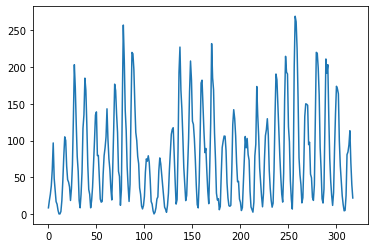

In [15]:
spots = load_sunspots()
plt.plot(spots)

### Sunspot cycle has periodicity

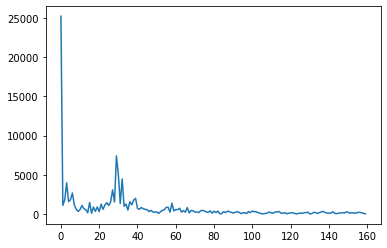

In [16]:
spectrum = rfft(spots)

plt.figure()
plt.plot(abs(spectrum))
plt.savefig("fixed.png")

### Years are not constant length


There's a potential problem with this analysis however:

* Years are not constant length
* Leap years exist
* But, the Fast Fourier Transform assumes evenly spaced intervals


### Strategy Pattern for Algorithms

### Uneven time series


The Fast Fourier Transform cannot be applied to uneven time series.

We could:

* Ignore this problem, and assume the effect is small;
* Interpolate and resample to even times;
* Use a method which is robust to unevenly sampled series, such as [LSSA](https://en.wikipedia.org/wiki/Least-squares_spectral_analysis);

We also want to find the period of the strongest periodic signal in the data, there are
various different methods we could use for this also, such as integrating the fourier series
by quadrature to find the mean frequency, or choosing the largest single value. 


### Too many classes!


We could implement a base class for our common code between the different approaches,
and define derived classes for each different algorithmic approach. However, this has drawbacks:

* The constructors for each derived class will need arguments for all the numerical method's control parameters,
such as the degree of spline for the interpolation method, the order of quadrature for integrators, and so on.
* Where we have multiple algorithmic choices to make (interpolator, periodogram, peak finder...) the number
of derived classes would explode: `class SunspotAnalyzerSplineFFTTrapeziumNearMode` is a bit unwieldy.
* The algorithmic choices are not then available for other projects
* This design doesn't fit with a clean Ontology of "kinds of things": there's no Abstract Base for spectrogram generators...


### Apply the strategy pattern:


* We implement each algorithm for generating a spectrum as its own Strategy class.
* They all implement a common interface
* Arguments to strategy constructor specify parameters of algorithms, such as spline degree
* One strategy instance for each algorithm is passed to the constructor for the overall analysis



First, we'll define a helper class for our time series.



In [17]:
class Series:
    """Enhance NumPy N-d array with some helper functions for clarity"""

    def __init__(self, data):
        self.data = array(data)
        self.count = self.data.shape[0]
        self.start = self.data[0, 0]
        self.end = self.data[-1, 0]
        self.range = self.end - self.start
        self.step = self.range / self.count
        self.times = self.data[:, 0]
        self.values = self.data[:, 1]
        self.plot_data = [self.times, self.values]
        self.inverse_plot_data = [1.0 / self.times[20:], self.values[20:]]


Then, our class which contains the analysis code, *except* the numerical methods




In [18]:
from datetime import datetime

class AnalyseSunspotData:
    def format_date(self, date):
        date_format = r"%Y-%m-%d"
        return datetime.strptime(date, date_format)

    def load_data(self, csv_file):
        start_date_str = "1700-12-31"
        end_date_str = "2014-01-01"
        self.start_date = self.format_date(start_date_str)
        end_date = self.format_date(end_date_str)
        url_base = f"https://www.quandl.com/api/v1/datasets/{csv_file}"
        x = requests.get(
            url_base,
            params={
                "trim_start": start_date_str,
                "trim_end": end_date_str,
                "sort_order": "asc",
            },
        )
        secs_per_year = (datetime(2014, 1, 1) - datetime(2013, 1, 1)).total_seconds()
        data = csv.reader(StringIO(x.text))
        # Convert requests result to look like a file buffer before reading with CSV
        next(data)  # Skip header row
        self.series = Series(
            [
                [
                    (self.format_date(row[0]) - self.start_date).total_seconds()
                    / secs_per_year,
                    float(row[1]),
                ]
                for row in data
            ]
        )

    def __init__(self, frequency_strategy):
        self.load_data("SIDC/SUNSPOTS_A.csv")
        self.frequency_strategy = frequency_strategy

    def frequency_data(self):
        return self.frequency_strategy.transform(self.series)


Our existing simple fourier strategy




In [19]:
class FourierNearestFrequencyStrategy:
    def transform(self, series):
        transformed = fft(series.values)[0 : series.count // 2]
        frequencies = fftfreq(series.count, series.step)[0 : series.count // 2]
        return Series(list(zip(frequencies, abs(transformed) / series.count)))


A strategy based on interpolation to a spline




In [20]:
class FourierSplineFrequencyStrategy:
    def next_power_of_two(self, value):
        "Return the next power of 2 above value"
        return 2 ** (1 + int(log(value) / log(2)))

    def transform(self, series):
        spline = UnivariateSpline(series.times, series.values)
        # Linspace will give us *evenly* spaced points in the series
        fft_count = self.next_power_of_two(series.count)
        points = linspace(series.start, series.end, fft_count)
        regular_xs = [spline(point) for point in points]
        transformed = fft(regular_xs)[0 : fft_count // 2]
        frequencies = fftfreq(fft_count, series.range / fft_count)[0 : fft_count // 2]
        return Series(list(zip(frequencies, abs(transformed) / fft_count)))


A strategy using the Lomb-Scargle Periodogram




In [21]:
# Currently this fails with "Invalid call to pythranized function". Investigation needed.
class LombFrequencyStrategy:
    def transform(self, series):
        frequencies = array(
            linspace(1.0 / series.range, 0.5 / series.step, series.count)
        )
        result = lombscargle(
            series.times,
            series.values,
            2.0 * math.pi * frequencies
        )
        return Series(list(zip(frequencies, sqrt(result / series.count))))


Define our concrete solutions with particular strategies




In [22]:
fourier_model = AnalyseSunspotData(FourierSplineFrequencyStrategy())
# lomb_model = AnalyseSunspotData(LombFrequencyStrategy())
nearest_model = AnalyseSunspotData(FourierNearestFrequencyStrategy())


Use these new tools to compare solutions




In [23]:
import numpy as np
import scipy.signal as signal
rng = np.random.default_rng()

nin = 1000
nout = 100000
frac_points = 0.9
A = 2.
w = 1.
phi = 0.5 * np.pi

r = rng.standard_normal(nin)
x = np.linspace(0.01, 10*np.pi, nin)
x = x[r >= frac_points]
y = A * np.sin(w*x+phi)
f = np.linspace(0.01, 10, nout)

pgram = signal.lombscargle(x, y, f, normalize=True)

In [24]:
comparison = fourier_model.frequency_data().inverse_plot_data + ["r"]
# comparison += lomb_model.frequency_data().inverse_plot_data + ["g"]
comparison += nearest_model.frequency_data().inverse_plot_data + ["b"]

In [25]:
deviation = 365 * (
    fourier_model.series.times
    - linspace(
        fourier_model.series.start, fourier_model.series.end, fourier_model.series.count
    )
)

(0.0, 16.0)

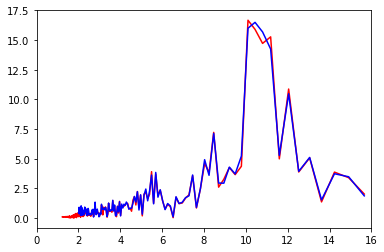

In [26]:
plt.plot(*comparison)
plt.xlim(0, 16)

### Results: Deviation of year length from average

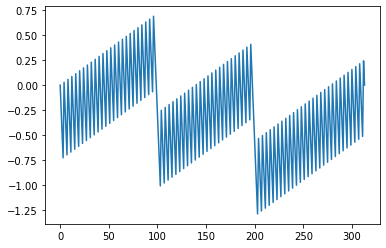

In [27]:
plt.plot(deviation)

## Model-View-Controller

### Separate graphics from science!


Whenever we are coding a simulation or model we want to:

* Implement the maths of the model
* Visualise, plot, or print out what is going on.

We often see scientific programs where the code which is used to display what is happening is mixed up with the
mathematics of the analysis. This is hard to understand.

We can do better by separating the `Model` from the `View`, and using a "`Controller`" to manage them.


### Model

This is where we describe our internal logic, rules, etc.

In [28]:
import numpy as np


class Model:
    def __init__(self):
        self.positions = np.random.rand(100, 2)
        self.speeds = np.random.rand(100, 2) + np.array([-0.5, -0.5])[np.newaxis, :]
        self.deltat = 0.01

    def simulation_step(self):
        self.positions += self.speeds * self.deltat

    def agent_locations(self):
        return self.positions

### View

This is where we describe what the user sees of our Model, what's displayed. You may have different type of visualisation (_e.g._, on one type of projection, a 3D view, a surface view, ...) which can be implemented in different _view_ classes.

In [29]:
class View:
    def __init__(self, model):
        from matplotlib import pyplot as plt

        self.figure = plt.figure()
        axes = plt.axes()
        self.model = model
        self.scatter = axes.scatter(
            model.agent_locations()[:, 0], model.agent_locations()[:, 1]
        )

    def update(self):
        self.scatter.set_offsets(self.model.agent_locations())

### Controller

This is the class that tells the view that the models has changed and updates the model with any change the user has input through the view.

In [30]:
from matplotlib import animation


class Controller:
    def __init__(self):
        self.model = Model()  # Or use Builder
        self.view = View(self.model)

    def animate(self, frame_number):
        self.model.simulation_step()
        self.view.update()

    def go(self):
        anim = animation.FuncAnimation(
            self.view.figure, self.animate, frames=200, interval=50
        )
        return anim.to_jshtml()

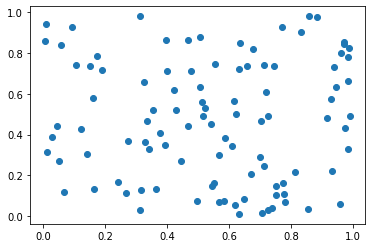

In [31]:
contl = Controller()

In [32]:
HTML(contl.go())

### Other resources

- [Course on design patterns](https://www.lynda.com/Python-tutorials/Design-Patterns-Python/369187-2.html) and [Advanced design patterns](https://www.lynda.com/Python-tutorials/Python-Advanced-Design-Patterns/656802-2.html) with Python at [Lynda.com](https://ucl.ac.uk/lynda).
- [A collection of design patterns and idioms in Python](https://github.com/faif/python-patterns).
- [Head First Desssign Patterns](http://www.worldcat.org/title/head-first-design-patterns/oclc/893944765) (Available [online at UCL](https://ucl-new-primo.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=UCL_LMS_DS51233633660004761&context=L&vid=UCL_VU2&search_scope=CSCOP_UCL&tab=local&lang=en_US)) - based on Java (with [online course at Lynda.com](https://www.lynda.com/Developer-Programming-Foundations-tutorials/Foundations-Programming-Design-Patterns/135365-2.html)).
- [Design Pattern for Dummies](http://www.worldcat.org/title/design-patterns-for-dummies/oclc/69537420&referer=brief_results).
